In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import matplotlib as plt
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from torch.nn import *
import cv2
# import wandb
# from wandb.fastai import WandbCallback

In [3]:
class CE_DiceLoss(nn.Module):
    def __init__(self):
        super(CE_DiceLoss, self).__init__()

    def forward(self, inp, target):
        inp = torch.sigmoid(inp)
        target = target.type(torch.FloatTensor).cuda()
        CE_val = nn.BCELoss(inp, target)
        dice_val = self.dice_loss(inp, target)
        
        return (CE_val + dice_val)/2
        
    def dice_loss(self, inp, target):
        smooth = 1.
        loss = 0.
        for c in range(n_classes):
            iflat = inp[:, c ].view(-1)
            tflat = target[:, c].view(-1)
            intersection = (iflat * tflat).sum()

            w = class_weights[c]
            loss += w * (1 - ((2. * intersection + smooth)/(iflat.sum() + tflat.sum() + smooth)))
        return loss

In [4]:
path = Path("/home/ubuntu/Kharbanda/Buildings")
path_img = path/'Images'
path_mask = path/'Masks'

In [5]:
all_img = get_image_files(path_img)
fname = [x for x in all_img if str(x.stem[:5]) == "3band"] 
fname[:5]

[PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/3band_AOI_1_RIO_img5750.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/3band_AOI_1_RIO_img6415.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/3band_AOI_1_RIO_img600.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/3band_AOI_1_RIO_img6329.tif'),
 PosixPath('/home/ubuntu/Kharbanda/Buildings/Images/3band_AOI_1_RIO_img435.tif')]

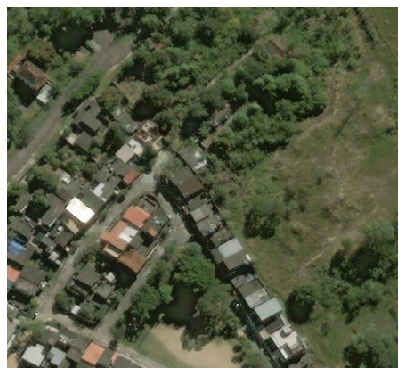

In [7]:
img = open_image(fname[14])
img.show(figsize=(7,7))

In [8]:
# string = 'Images/'
# data = [string + x.name for x in fname]

# v1_df = pd.DataFrame(data, columns = ['Images'])
# v1_df.to_csv("Rio_buildings.csv")

In [6]:
rio_df = pd.read_csv(path/'Rio_buildings.csv')
rio_df = rio_df.drop(columns = 'Unnamed: 0')
rio_df.head()

,Images
0,Images/3band_AOI_1_RIO_img5750.tif
1,Images/3band_AOI_1_RIO_img6415.tif
2,Images/3band_AOI_1_RIO_img600.tif
3,Images/3band_AOI_1_RIO_img6329.tif
4,Images/3band_AOI_1_RIO_img435.tif


In [7]:
len(rio_df)

6940

In [8]:
get_y_fn = lambda x: path_mask/f'{Path(x).name}'

In [9]:
def save_model(model, City, Freezed='F', Size='smol', Iter = 1):
    model.save(f'{City}_{Freezed}_{Size}_{Iter}')
    
def load_model(model, City, Freezed='F', Size='smol', Iter = 1):
    model.load(f'{City}_{Freezed}_{Size}_{Iter}')

In [10]:
codes = [0,'building']
random.seed(42)
src = (SegmentationItemList.from_df(rio_df, path).
      split_by_rand_pct(.1).
      label_from_func(get_y_fn, classes=codes))

In [13]:
bs = 64
size = 224
data = (src.transform(get_transforms(flip_vert = True, max_rotate = 15, max_zoom=1.2, max_lighting = 0.5,
                                    xtra_tfms = [brightness(change=0.56, p=1), contrast(scale=(1, 1.75), p=1.)]),
                      size = size, tfm_y=True).
       databunch(bs=bs).normalize(imagenet_stats))

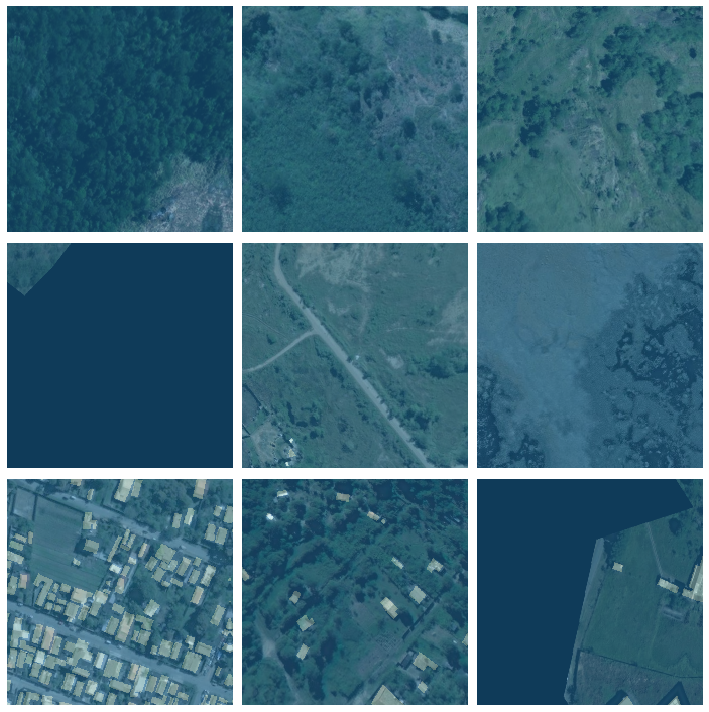

In [11]:
data.show_batch(3, figsize=(10,10))

In [14]:
# wd = 1e-3
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, 
                     norm_type=NormType.Weight, self_attention=True).to_fp16()
learn.loss = CE_DiceLoss

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


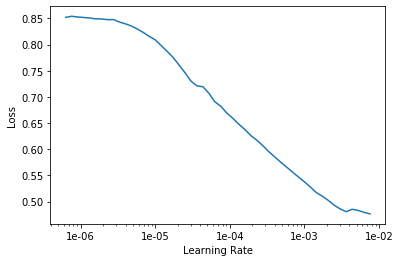

In [15]:
learn.lr_find()
learn.recorder.plot() 

In [16]:
learn.fit_one_cycle(5, slice(1e-3))

epoch,train_loss,valid_loss,dice,time
0,0.201363,0.138716,0.273998,01:00
1,0.149751,0.114915,0.499852,00:57
2,0.131450,0.116056,0.529878,00:58
3,0.122220,0.107399,0.531713,00:57
4,0.120041,0.106434,0.537361,00:57


In [17]:
save_model(learn, 'Rio_DA', 'F', 'smol', 1)

# Start Recording

In [11]:
import wandb
from wandb.fastai import WandbCallback

In [19]:
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight,
                    self_attention=True, callback_fns=partial(WandbCallback, input_type='images')).to_fp16()
learn.loss = CE_DiceLoss

In [20]:
os.environ['WANDB_NOTEBOOK_NAME']="SpaceNet Buildings Rio.ipynb"

In [21]:
wandb.init(project="spacenet_buildings", name = 'Rio_smol_DA')

W&B Run: https://app.wandb.ai/kharbanda/spacenet_buildings/runs/kdw1e29i

In [22]:
load_model(learn, 'Rio_DA', 'F', 'smol', 1)

In [23]:
learn.fit_one_cycle(10, slice(1e-4, 1e-3), pct_start=0.6)

epoch,train_loss,valid_loss,dice,time
0,0.118179,0.105630,0.540879,00:59
1,0.119186,0.107815,0.539358,00:58
2,0.120040,0.105949,0.488915,00:58
3,0.119539,0.103932,0.540777,00:58
4,0.125743,0.105201,0.547690,00:58
5,0.121189,0.101931,0.527348,00:58
6,0.118864,0.100370,0.549174,00:58
7,0.115184,0.099611,0.561657,00:58
8,0.110315,0.098528,0.562968,00:58
9,0.109635,0.098136,0.565312,00:58


Better model found at epoch 0 with valid_loss value: 0.10563027858734131.
Better model found at epoch 3 with valid_loss value: 0.10393242537975311.
Better model found at epoch 5 with valid_loss value: 0.10193094611167908.
Better model found at epoch 6 with valid_loss value: 0.10037032514810562.
Better model found at epoch 7 with valid_loss value: 0.09961087256669998.
Better model found at epoch 8 with valid_loss value: 0.09852775186300278.
Better model found at epoch 9 with valid_loss value: 0.09813577681779861.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200114_125756-kdw1e29i/bestmodel.pth


In [24]:
save_model(learn, 'Rio_DA', 'F', 'smol', 2)

In [25]:
learn.unfreeze()

In [26]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.107133,0.097724,0.559023,00:59
1,0.108251,0.097623,0.562075,00:59
2,0.111292,0.097363,0.560453,00:59
3,0.110410,0.098381,0.567454,00:59
4,0.107605,0.097546,0.567878,00:59
5,0.108792,0.099261,0.570640,00:59
6,0.108171,0.097415,0.556350,00:59
7,0.105797,0.096162,0.564525,00:58
8,0.108107,0.096301,0.563160,00:59
9,0.106642,0.096030,0.566872,00:59


Better model found at epoch 0 with valid_loss value: 0.0977238267660141.
Better model found at epoch 1 with valid_loss value: 0.09762286394834518.
Better model found at epoch 2 with valid_loss value: 0.09736323356628418.
Better model found at epoch 7 with valid_loss value: 0.09616171568632126.
Better model found at epoch 9 with valid_loss value: 0.09602978080511093.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200114_125756-kdw1e29i/bestmodel.pth


In [27]:
save_model(learn, 'Rio_DA', 'UF', 'smol', 1)

In [28]:
learn.fit_one_cycle(10, slice(1e-6, 1e-5), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.106251,0.096122,0.568028,00:59
1,0.105491,0.096155,0.568662,00:59
2,0.108847,0.096241,0.569444,00:59
3,0.106842,0.096408,0.569314,00:59
4,0.106856,0.095732,0.570160,00:59
5,0.105690,0.095819,0.568443,00:59
6,0.107076,0.095907,0.566884,00:59
7,0.106844,0.095613,0.567326,00:59
8,0.107131,0.095806,0.569590,00:59
9,0.106608,0.095629,0.568036,00:59


Better model found at epoch 0 with valid_loss value: 0.0961223915219307.
Better model found at epoch 4 with valid_loss value: 0.09573224931955338.
Better model found at epoch 7 with valid_loss value: 0.09561318904161453.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200114_125756-kdw1e29i/bestmodel.pth


In [29]:
save_model(learn, 'Rio_DA', 'UF', 'small', 2)

# GO BIG

In [20]:
# ref_img = [x for x in fname if list(open_mask(get_y_fn(x)).data.unique()) == list(tensor([0,1]))]

# string = 'Images/'
# data = [string + x.name for x in ref_img]

# v1_df = pd.DataFrame(data, columns = ['Images'])
# v1_df.to_csv("Rio_C_buildings.csv")

In [12]:
rio_df = pd.read_csv(path/'Rio_C_buildings.csv')
rio_df = rio_df.drop(columns = 'Unnamed: 0')
rio_df.head()

,Images
0,Images/3band_AOI_1_RIO_img5750.tif
1,Images/3band_AOI_1_RIO_img435.tif
2,Images/3band_AOI_1_RIO_img3455.tif
3,Images/3band_AOI_1_RIO_img5529.tif
4,Images/3band_AOI_1_RIO_img4895.tif


In [13]:
src = (SegmentationItemList.from_df(rio_df, path).
      split_by_rand_pct(.1).
      label_from_func(get_y_fn, classes=codes))

In [14]:
bs = 16
size = 400
data = (src.transform(get_transforms(flip_vert = True, max_rotate = 15, max_zoom=1.2, max_lighting = 0.5,
                                    xtra_tfms = [brightness(change=0.56, p=1), contrast(scale=(1, 1.75), p=1.)]),
                      size = size, tfm_y=True).
       databunch(bs=bs).normalize(imagenet_stats))

In [15]:
di = partial(dice, iou=True)
learn = unet_learner(data, models.resnet34, metrics = [di], blur=True, norm_type=NormType.Weight,
                    self_attention=True, callback_fns=partial(WandbCallback, input_type='images')).to_fp16()
learn.loss = CE_DiceLoss

In [14]:
load_model(learn, 'Rio_DA', 'UF', 'small', 2)

In [16]:
os.environ['WANDB_NOTEBOOK_NAME']="SpaceNet Buildings Vegas.ipynb"

In [17]:
wandb.init(project="spacenet_buildings", name = 'Rio_Big_SA_DA')

W&B Run: https://app.wandb.ai/kharbanda/spacenet_buildings/runs/asbxqh46

In [17]:
learn.fit_one_cycle(10, slice(5e-5, 5e-4), pct_start=0.7)

epoch,train_loss,valid_loss,dice,time
0,0.178032,0.155595,0.589540,02:18
1,0.179335,0.155016,0.595536,02:03
2,0.173482,0.157510,0.556219,02:03
3,0.171394,0.153250,0.582695,02:02
4,0.175592,0.153425,0.594955,02:03
5,0.171325,0.153794,0.597568,02:02
6,0.172395,0.158502,0.604201,02:03
7,0.171296,0.151486,0.606140,02:03
8,0.166963,0.150205,0.606780,02:03
9,0.163591,0.148661,0.604199,02:03


Better model found at epoch 0 with valid_loss value: 0.15559455752372742.
Better model found at epoch 1 with valid_loss value: 0.15501613914966583.
Better model found at epoch 3 with valid_loss value: 0.15325042605400085.
Better model found at epoch 7 with valid_loss value: 0.15148580074310303.
Better model found at epoch 8 with valid_loss value: 0.1502048373222351.
Better model found at epoch 9 with valid_loss value: 0.14866125583648682.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200114_150627-m6kort0m/bestmodel.pth


In [18]:
save_model(learn, 'Rio_DA', 'F', 'big', 1)

In [18]:
load_model(learn, 'Rio_DA', 'F', 'big', 1)

In [19]:
learn.unfreeze()

In [20]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.158661,0.154425,0.594257,02:23
1,0.163671,0.154285,0.593475,02:03
2,0.162725,0.154448,0.587475,02:03
3,0.165571,0.154837,0.589961,02:04
4,0.168223,0.153537,0.590656,02:03
5,0.160605,0.153798,0.593959,02:04
6,0.161193,0.154177,0.595862,02:04
7,0.163178,0.154736,0.589112,02:03
8,0.162486,0.154130,0.599056,02:04
9,0.156194,0.153052,0.595372,02:04


Better model found at epoch 0 with valid_loss value: 0.15442506968975067.
Better model found at epoch 1 with valid_loss value: 0.1542845070362091.
Better model found at epoch 4 with valid_loss value: 0.15353700518608093.
Better model found at epoch 9 with valid_loss value: 0.15305231511592865.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200114_202053-asbxqh46/bestmodel.pth


In [21]:
save_model(learn, 'Rio_DA', 'UF', 'big', 1)

In [22]:
learn.fit_one_cycle(10, slice(1e-6, 5e-5), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.163283,0.152805,0.594114,02:02
1,0.161447,0.152826,0.592593,02:02
2,0.158208,0.153142,0.592748,02:02
3,0.153959,0.152978,0.595841,02:03
4,0.164243,0.153224,0.596829,02:04
5,0.155793,0.153558,0.595859,02:03
6,0.163752,0.152577,0.596929,02:02
7,0.162872,0.153467,0.593327,02:03
8,0.161129,0.152645,0.592998,02:04
9,0.161594,0.152282,0.592558,02:02


Better model found at epoch 0 with valid_loss value: 0.15280450880527496.
Better model found at epoch 6 with valid_loss value: 0.15257713198661804.
Better model found at epoch 9 with valid_loss value: 0.15228167176246643.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200114_202053-asbxqh46/bestmodel.pth


In [27]:
save_model(learn, 'Rio', 'UF', 'big', 2)

In [23]:
learn.fit_one_cycle(10, slice(5e-7, 5e-6), pct_start = 0.7)

epoch,train_loss,valid_loss,dice,time
0,0.158017,0.152341,0.593760,02:03
1,0.156181,0.152471,0.595271,02:03
2,0.158325,0.152408,0.594034,02:03
3,0.154590,0.152253,0.593547,02:03
4,0.158647,0.152772,0.596831,02:02
5,0.163311,0.152243,0.592208,02:02
6,0.156902,0.152311,0.595398,02:02
7,0.152981,0.152364,0.594263,02:02
8,0.154923,0.152417,0.594061,02:03
9,0.152301,0.152225,0.594232,02:03


Better model found at epoch 0 with valid_loss value: 0.15234073996543884.
Better model found at epoch 3 with valid_loss value: 0.1522529274225235.
Better model found at epoch 5 with valid_loss value: 0.15224315226078033.
Better model found at epoch 9 with valid_loss value: 0.15222515165805817.
Loaded best saved model from /home/ubuntu/Kharbanda/Buildings/wandb/run-20200114_202053-asbxqh46/bestmodel.pth


In [29]:
save_model(learn, 'Rio', 'UF', 'big', 3)